# NO PANDAS!

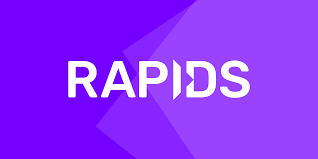

# Environment

In [ ]:
import sys
!cp ../input/rapids/rapids.0.13.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.6"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

# Imports

In [ ]:
import gc
import cudf
import pynvml
import numpy as np
import xgboost as xgb
from math import sqrt
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error,f1_score, accuracy_score

# Reading (not using pandas)

In [ ]:
train = cudf.read_csv('../input/ion-switch-model-ready-data-frame-to-work-locally/train_ion_switch.csv')
test  = cudf.read_csv('../input/ion-switch-model-ready-data-frame-to-work-locally/test_ion_switch.csv')

# preparing train / test / target

In [ ]:
y     = train['open_channels']
train = train.drop(['open_channels'],axis=1)

train = train.drop('time', axis = 1)
test  = test.drop( 'time', axis = 1)

# train-test split (again not pandas)

In [ ]:
from cuml import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=123)

# Train

In [ ]:
dtrain = xgb.DMatrix(X_train,y_train)
dval   = xgb.DMatrix(X_test, y_test)
dtest  = xgb.DMatrix(test)

evallist = [(dval, 'validation'), (dtrain, 'train')]
num_round=7500

In [ ]:
trained_model = xgb.train(
                        {
                          'learning_rate': 0.01,
                          'colsample_bytree' : 0.25,
                          'max_depth': 10,
                          'objective': 'reg:squarederror',
                          'silent': True,
                          'tree_method':'gpu_hist',
                        },
                        dtrain,num_round, evallist,verbose_eval=500)

# Predict

In [ ]:
prediction = trained_model.predict(dtest)

# Submission

### still no pandas 

In [ ]:
sub = cudf.read_csv("../input/liverpool-ion-switching/sample_submission.csv")

submission = cudf.DataFrame()
submission['time']  = sub['time']
submission['open_channels'] = prediction
submission['open_channels'] = submission['open_channels'].round(decimals=0)
submission['open_channels'] = submission['open_channels'].astype(int)
submission.to_csv('submission.csv', index = False)

In [ ]:
submission.tail()